In [1]:
import pandas as pd
import numpy as np
import tqdm
import os
import gc
import copy

import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Extract data and Divide into train/test

Here, we will extract all the information regarding train and test data

In [2]:
file_path = "C:\\UMD\\Sem 2\\MSML605 Computing Systems\\Homeworks\\Project\\CUB_200_2011"

images = pd.read_csv(f"{file_path}\\images.txt", 
                     sep=' ', 
                     names=['image_id', 'image_name'])
train_test = pd.read_csv(f"{file_path}\\train_test_split.txt", 
                     sep=' ', 
                     names=['image_id', 'is_training_image'])
classes = pd.read_csv(f"{file_path}\\classes.txt", 
                     sep=' ', 
                     names=['class_id', 'class_name'])
image_class_labels = pd.read_csv(f"{file_path}\\image_class_labels.txt", 
                     sep=' ', 
                     names=['image_id', 'class_id'])

bounding_boxes = pd.read_csv(f'{file_path}\\bounding_boxes.txt',
                             sep=' ',
                             names=['image_id', 'x', 'y', 'width', 'height'])
bounding_boxes = bounding_boxes.astype(int)
#Merging the information given
image_data = images.merge(train_test, on='image_id', how='inner')

labels_data = classes.merge(image_class_labels, on='class_id', how='inner')

image_data = image_data.merge(labels_data, on='image_id', how='inner')

image_data = image_data.merge(bounding_boxes, on='image_id', how='inner')
image_data

,image_id,image_name,is_training_image,class_id,class_name,x,y,width,height
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,0,1,001.Black_footed_Albatross,60,27,325,304
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,139,30,153,264
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,0,1,001.Black_footed_Albatross,14,112,388,186
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,112,90,255,242
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,70,50,134,303
...,...,...,...,...,...,...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,1,200,200.Common_Yellowthroat,89,95,354,250
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,200,200.Common_Yellowthroat,157,62,184,219
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,200,200.Common_Yellowthroat,190,102,198,202
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,1,200,200.Common_Yellowthroat,3,20,408,307


Now, we divide into train and test data using the information given

In [3]:
# Set the first 24 training values in each group to 0 
grouped = image_data[image_data['is_training_image'] == 1].groupby('class_name')
validation_indices = []

for name, group in grouped: 
    validation_indices.extend(group.index[24:])

# Set the first 24 values in each group to 0
image_data['is_validation_image'] = 0
image_data.loc[validation_indices, 'is_validation_image'] = 1
image_data['is_validation_image'].value_counts()

is_validation_image
0    10594
1     1194
Name: count, dtype: int64

In [4]:
#Split the data into training and test
train_indices = (image_data['is_training_image'] == 1) & (image_data['is_validation_image'] == 0)
training_data = image_data[train_indices].reset_index()
validation_data = image_data[image_data['is_validation_image'] == 1].reset_index()
test_data = image_data[image_data['is_training_image'] == 0].reset_index()

#Setting three sets of images: training, validation, and test
X_temp_train = []
X_temp_validation = []
X_temp_test = []
temp = [X_temp_train, X_temp_validation, X_temp_test]

for p, dataframe in enumerate([training_data, validation_data, test_data]):
    #Get the paths for the images
    paths = 'CUB_200_2011/images/' + np.array(dataframe['image_name'])
    
    #Get the image arrays
    for i, img in tqdm.tqdm(enumerate(paths), total=dataframe.shape[0]):
        image = cv2.imread(img)
        x, y, width, height = dataframe.loc[i, ['x', 'y', 'width', 'height']]
        temp[p].append(image[y:y+height, x:x+width, :])
    
len(X_temp_train), len(X_temp_validation), len(X_temp_test)

  0%|          | 0/4800 [00:00<?, ?it/s]

100%|██████████| 5794/5794 [01:13<00:00, 78.36it/s]


(4800, 1194, 5794)

# Data Preprocessing

Padding all to square and then reshaping all to 224x224

In [5]:
def convert_to_PIL(image):
    return Image.fromarray(image)

# Define the transformation pipeline
transform = transforms.Compose([
    convert_to_PIL,
    # transforms.Resize(256),  # Resize the shorter side to 256, preserving aspect ratio
    # transforms.CenterCrop(224),  # Center crop to 224x224
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


final_image_size = (224, 224)


In [6]:
X_train, X_validation, X_test = [], [], []
for i, img in tqdm.tqdm(enumerate(X_temp_train), total=len(X_temp_train)):
    X_train.append(transform(img))

for i, img in tqdm.tqdm(enumerate(X_temp_validation), total=len(X_temp_validation)):
    X_validation.append(transform(img))

for i, img in tqdm.tqdm(enumerate(X_temp_test), total=len(X_temp_test)):
    X_test.append(transform(img))

100%|██████████| 5794/5794 [00:28<00:00, 205.25it/s]


In [7]:
y_train = np.array(image_data[train_indices]['class_id']) - 1

In [8]:
# train_transform = transforms.Compose([
#     convert_to_PIL,
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(10),
#     transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.RandomErasing(inplace=True),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# for i, img in tqdm.tqdm(enumerate(X_temp_train), total=len(X_temp_train)):
#     X_train.append(train_transform(img))

# y_train = np.array(image_data[train_indices]['class_id']) - 1
# y_train = np.concatenate([y_train, y_train])

In [8]:
# Convert the list of tensors to a 4D tensor (N, H, W, C)
X_train = torch.stack(X_train)   
print("Train done")

X_validation = torch.stack(X_validation) 
print("Validation done")

X_test = torch.stack(X_test)
print("Test done")   

print(X_train.shape, X_validation.shape, X_test.shape)

Train done
Validation done
Test done
torch.Size([4800, 3, 224, 224]) torch.Size([1194, 3, 224, 224]) torch.Size([5794, 3, 224, 224])


Setting labels

In [9]:
# Set the labels for training, validation and test
# y_validation = np.array(image_data[image_data['is_validation_image'] == 1]['class_id']) - 1
y_validation = np.array(image_data[image_data['is_validation_image'] == 1]['class_id']) - 1
y_test = np.array(image_data[image_data['is_training_image'] == 0]['class_id']) - 1

# dtype=torch.float, torch.long
y_train = torch.Tensor(y_train)
y_validation = torch.Tensor(y_validation).long()
y_test = torch.Tensor(y_test).long()
len(y_train), len(y_validation), len(y_test)

(4800, 1194, 5794)

Creating DataLoader

In [10]:
TrainDataset = data.TensorDataset(X_train, y_train)
ValidationDataset = data.TensorDataset(X_validation, y_validation)
TestDataset = data.TensorDataset(X_test, y_test)

batch_size = 2
TrainLoader = data.DataLoader(dataset=TrainDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)

ValidationLoader = data.DataLoader(dataset=ValidationDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)

TestLoader = data.DataLoader(dataset=TestDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)

len(TrainDataset), len(ValidationDataset), len(TestDataset)

(4800, 1194, 5794)

In [11]:
gc.collect()
torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


GroundTruth:  147.0 168.0


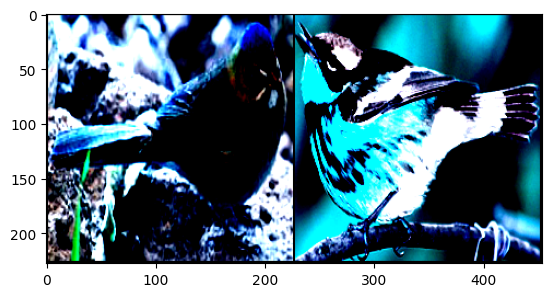

In [12]:
dataiter = iter(TrainLoader)
images, labels = next(dataiter)

# print images
plt.imshow(torchvision.utils.make_grid(images, nrow=10).permute(1, 2, 0))
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(2)))

Calculating accuracy function

In [13]:
def calculate_accuracy(model, loader, data_type='training'):
    model.eval() # Set model to evaluation mode

    correct = total = 0
    with torch.no_grad():
        for input_data in tqdm.tqdm(loader, total=len(loader)):
            # Move images to device (GPU if available)
            images, labels = input_data[0].to(device), input_data[1].to(device)
            
            #Predict values and convert to non-onehot vector
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            #For training, there will be onehot vector, so convert from onehot
            if data_type == 'training': 
                _, labels = torch.max(labels.data, 1)
            
            #Compare with ground truth
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the network on the {len(loader)} {data_type} images: {100 * correct / total}')
    return 100 * correct/total
    


# Model

In [15]:
# class Model(nn.Module):
#     def __init__(self, img_dim):
#         super().__init__()
#         #Assume input image is of size 224 x 224 are we are sending RGB (3 inputs)
#         #Input: RGB Image (3 inputs. Size: 224x224). 
#         #Output: 32 * (224 * 224). Since padding is same, no dimension change.
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, 
#                             kernel_size=3, padding='same')
#         #Since kernel size is 2 and no stride is given, stride = kernel_size.
#         #Output 32 * (112 * 112). Due to stride.
#         self.pool1 = nn.MaxPool2d(kernel_size=2)
        
#         #Input: 32 * (112 * 112). 32 inputs, size: 112 * 112 
#         #Output: 64 * (112 * 112). Since padding is same, no dimension change.
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,
#                             kernel_size=3, padding='same')
#         #Since kernel size is 2 and no stride is given, stride = kernel_size.
#         #Output 64 * (56 * 56). Due to stride.
#         self.pool2 = nn.MaxPool2d(kernel_size=2)

        
#         #Input: 64 * (56 * 56). 32 inputs, size: 56 * 56 
#         #Output: 128 * (28 * 28). Since padding is same, no dimension change.
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128,
#                             kernel_size=3, padding='same')
        
#         #Since kernel size is 2 and no stride is given, stride = kernel_size.
#         #Output 128 * (28 * 28). Due to stride.
#         self.pool3 = nn.MaxPool2d(kernel_size=2)
        
#         self.flatten = nn.Flatten()
#         self.d1 = nn.Linear(in_features=128 * img_dim[0]//8 * img_dim[1]//8, 
#                             out_features=512)
        
#         # self.dropout1 = nn.Dropout(p=0.4)
#         self.relu1 = nn.ReLU()
#         self.d2 = nn.Linear(in_features=512, out_features=200)
#         # self.dropout2 = nn.Dropout(p=0.4)
#         # self.d3 = nn.Linear(in_features=128, out_features=200)

#     def forward(self, x):
#         x = self.conv1(x)  
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = self.pool2(x)
#         x = self.conv3(x)
#         x = self.pool3(x)
#         x = self.flatten(x)
#         x = self.relu1(self.d1(x))
#         x = self.d2(x)
#         # x = nn.Softmax(self.d3(x))
#         return x
    

# Training

In [14]:
# Load the pretrained ResNet-18 model
NewModel = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modify the final fully connected layers
num_classes = 200  # Replace with the number of bird species

# Redefine the fc layers
NewModel.fc = nn.Linear(NewModel.fc.in_features, num_classes)

# Unfreeze all layers 
for param in NewModel.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()


NewModel.to(device)


c:\UMD\.venv\Lib\site-packages\torch\nn\modules\module.py:1159: UserWarning: expandable_segments not supported on this platform (Triggered internally at ..\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Check Initial Loss

log(C) for softmax for C classes

In [15]:
def calculate_loss(model, loader, criterion):
    model.eval() # Set model to evaluation mode

    running_loss = 0
    with torch.no_grad():
        for input_data in tqdm.tqdm(loader, total=len(loader)):
            # Move images to device (GPU if available)
            images, labels = input_data[0].to(device), input_data[1].to(device)
            
            #Predict values and convert to non-onehot vector
            outputs = model(images)
            loss = criterion(outputs, labels.long())
            running_loss += loss.item()

    return running_loss / len(loader)

calculate_loss(NewModel, TrainLoader, criterion)


100%|██████████| 2400/2400 [00:27<00:00, 87.37it/s] 


5.588722192148367

In [16]:
- np.log(1/200)

5.298317366548036

We can observe that the loss is nearly as expected. This means that our model is not making any mistake.

The loss should be $log(C)$ where $C$ is the number of classes.

The reason is that the cross entropy is defined as 
$$\frac{1}{N}\sum_{i = 1}^{N}-y_i log(p_i)$$ 
where $y_i = 1$ for correct $i$ and the probability $p_i = \frac{1}{C}$

## Overfit a small sample

We need to get 100% training accuracy on a small sample of training data (5 - 10 minibatches). No weight initialization and regularization.

Bad initialization conditions
- If loss is not going down, LR is too low 
- If loss explodes to `np.inf` or `NaN`, LR is too high

In [17]:
def overfit_model(NewModel, Loader, optimizer, criterion, num_epochs=30):
    training_loss = []
    training_accuracy = []

    for epoch in range(num_epochs):
        NewModel.train()

        running_loss = 0    
        for input_data, labels in tqdm.tqdm(Loader, total=len(Loader)):
            # Forward pass
            labels, input_data = labels.to(device), input_data.to(device)
            output = NewModel(input_data)
            
            # Compute loss
            loss = criterion(output, labels.long())
            running_loss += loss.item()
            # Backward pass
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Compute gradients
            optimizer.step()  # Update weights
            
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        training_loss.append(running_loss / len(Loader))
        training_accuracy.append(calculate_accuracy(NewModel, Loader, data_type='train'))
    
    return training_loss, training_accuracy

def plot_training_plots(training_loss, training_accuracy):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].plot(range(len(training_loss)), training_loss)
    ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
    ax[1].grid()
    ax[0].grid()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Training Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.show()

In [18]:
SampleDataset = data.TensorDataset(X_train[:batch_size * 10], y_train[:batch_size * 10])

SampleLoader = data.DataLoader(dataset=SampleDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)
len(SampleLoader)

10

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch [1/10], Loss: 0.0585


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Epoch [2/10], Loss: 0.0011


100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch [3/10], Loss: 0.0001


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch [4/10], Loss: 0.0000


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch [5/10], Loss: 0.0002


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch [6/10], Loss: 0.0000


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch [7/10], Loss: 0.0001


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Epoch [8/10], Loss: 0.0002


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch [9/10], Loss: 0.0000


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch [10/10], Loss: 0.0001


100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Accuracy of the network on the 10 train images: 100.0


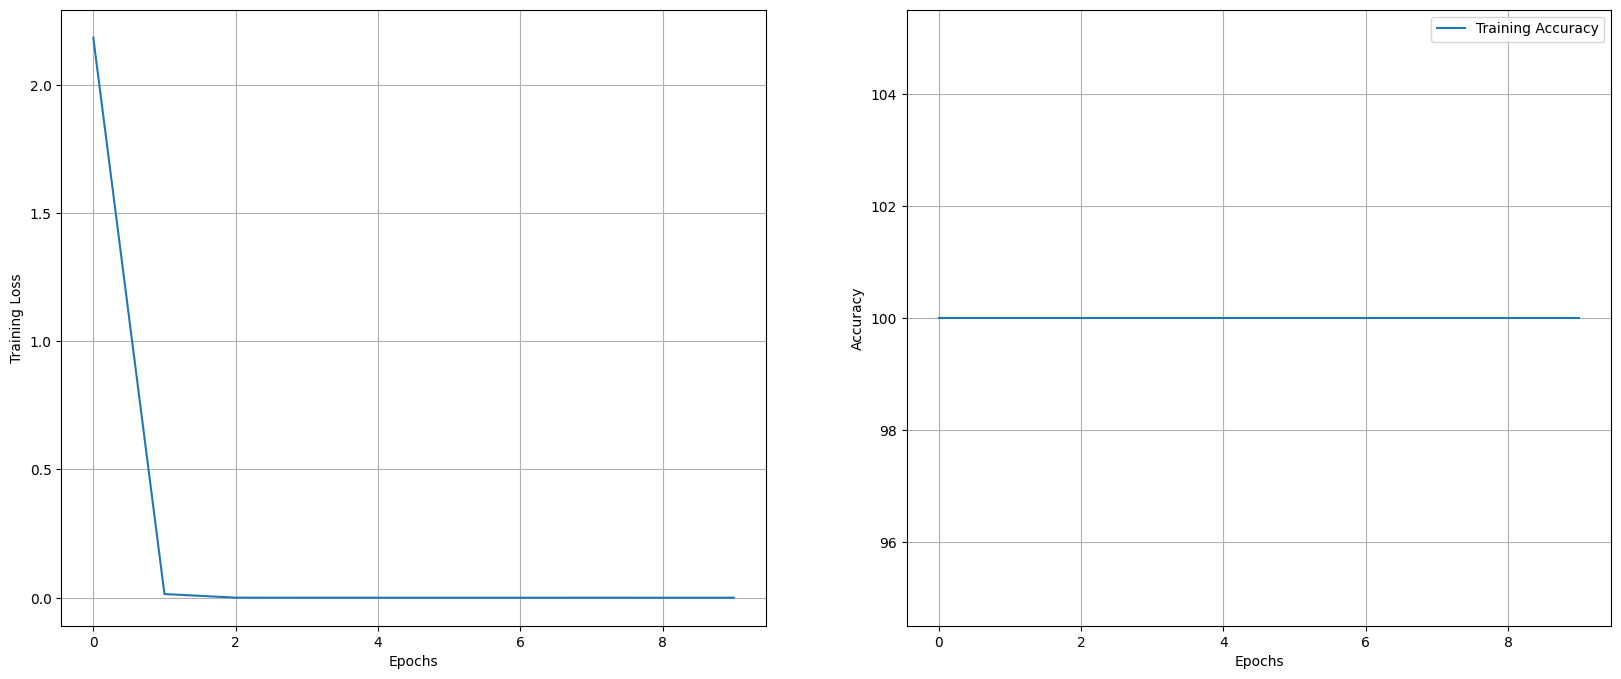

In [19]:
checkModel = copy.deepcopy(NewModel)
checkModel.to(device)

optimizer = optim.Adam(params=checkModel.parameters(), lr=0.001, weight_decay=0)

torch.cuda.empty_cache()
gc.collect()

adam_training_loss, adam_training_accuracy = overfit_model(checkModel, SampleLoader, optimizer, criterion, num_epochs=10)
plot_training_plots(adam_training_loss, adam_training_accuracy)

We can observe that Adam optimizer can overfit a sample with the given optimizers.

100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch [1/10], Loss: 2.1087


100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Epoch [2/10], Loss: 0.4187


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch [3/10], Loss: 0.1768


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch [4/10], Loss: 0.0929


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch [5/10], Loss: 0.0702


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch [6/10], Loss: 0.0875


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Epoch [7/10], Loss: 0.0437


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Epoch [8/10], Loss: 0.0395


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch [9/10], Loss: 0.0293


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch [10/10], Loss: 0.0366


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Accuracy of the network on the 10 train images: 100.0


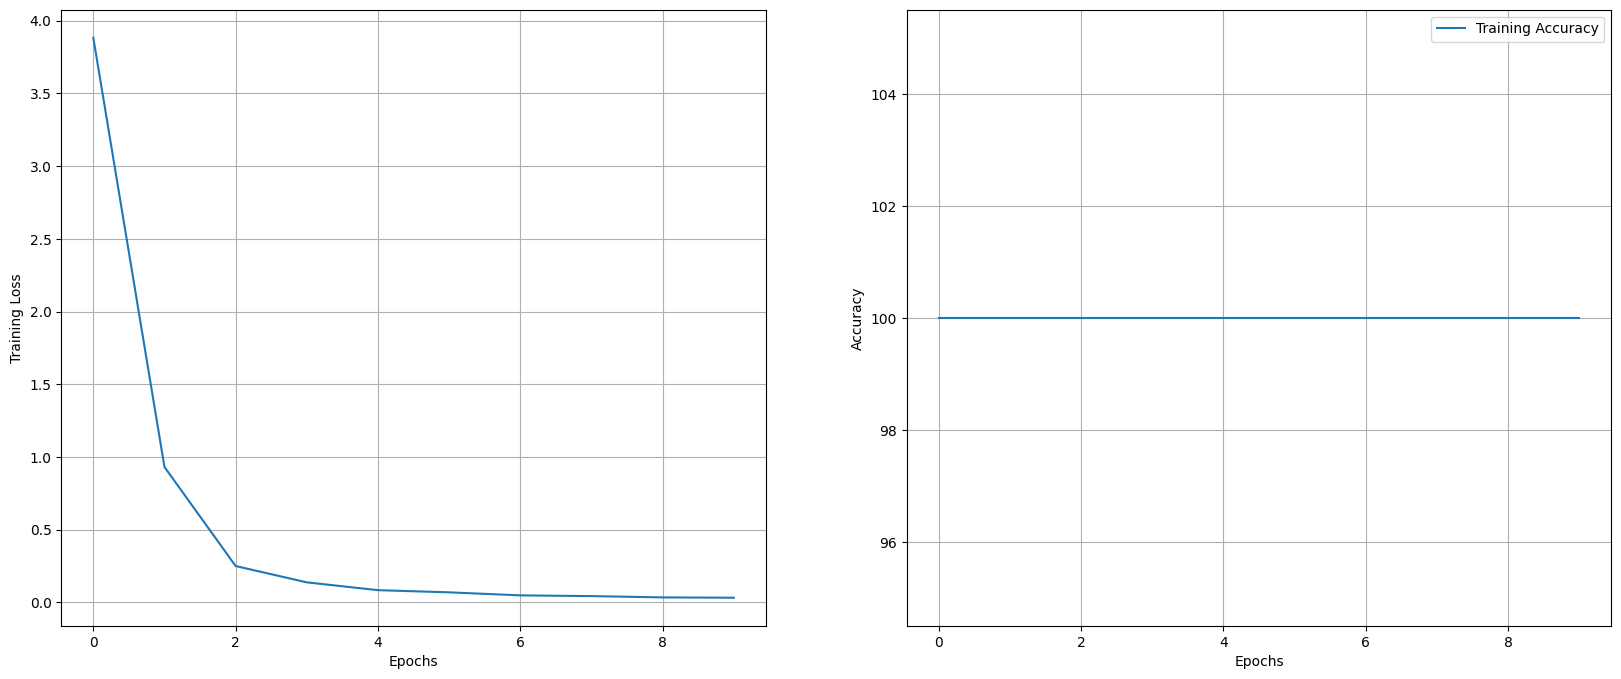

In [20]:
checkModel = copy.deepcopy(NewModel)
checkModel.to(device)
# Create a StepLR scheduler
optimizer = optim.SGD(params=checkModel.parameters(), lr=0.001, weight_decay=0)
#, momentum=0.9, weight_decay=0.0001)
# optimizer = optim.Adam(params=checkModel.parameters(), lr=0.0001, weight_decay=0)

torch.cuda.empty_cache()
gc.collect()

sgd_training_loss, sgd_training_accuracy = overfit_model(checkModel, SampleLoader, optimizer, criterion, num_epochs=10)
plot_training_plots(training_loss=sgd_training_loss, training_accuracy=sgd_training_accuracy)

100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Epoch [1/10], Loss: 0.0022


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


Epoch [2/10], Loss: 0.0000


100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch [3/10], Loss: 0.0000


100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch [4/10], Loss: 0.0000


100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch [5/10], Loss: 0.0000


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch [6/10], Loss: 0.0000


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch [7/10], Loss: 0.0000


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Epoch [8/10], Loss: 0.0000


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch [9/10], Loss: 0.0000


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch [10/10], Loss: 0.0000


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Accuracy of the network on the 10 train images: 100.0


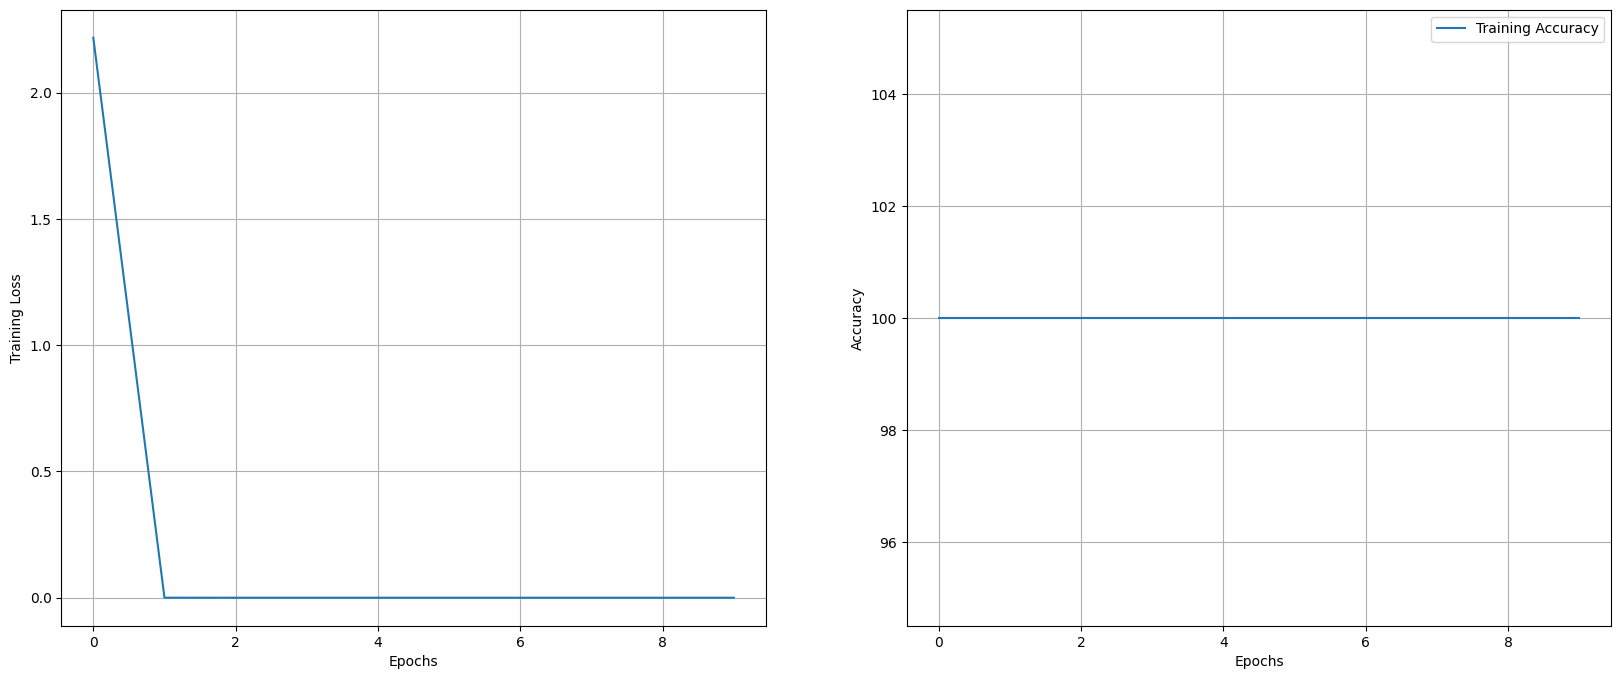

In [21]:
checkModel = copy.deepcopy(NewModel)
checkModel.to(device)
# Create a StepLR scheduler
optimizer = optim.SGD(params=checkModel.parameters(), lr=0.001, weight_decay=0, momentum=0.9)
#, momentum=0.9, weight_decay=0.0001)
# optimizer = optim.Adam(params=checkModel.parameters(), lr=0.0001, weight_decay=0)

torch.cuda.empty_cache()
gc.collect()

msgd_training_loss, msgd_training_accuracy = overfit_model(checkModel, SampleLoader, optimizer, criterion, num_epochs=10)
plot_training_plots(training_loss=msgd_training_loss, training_accuracy=msgd_training_accuracy)

100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch [1/10], Loss: 0.0556


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch [2/10], Loss: 0.0025


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Epoch [3/10], Loss: 0.0001


100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Epoch [4/10], Loss: 0.0001


100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch [5/10], Loss: 0.0001


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


Epoch [6/10], Loss: 0.0001


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch [7/10], Loss: 0.0000


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Epoch [8/10], Loss: 0.0000


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Epoch [9/10], Loss: 0.0000


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch [10/10], Loss: 0.0000


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Accuracy of the network on the 10 train images: 100.0


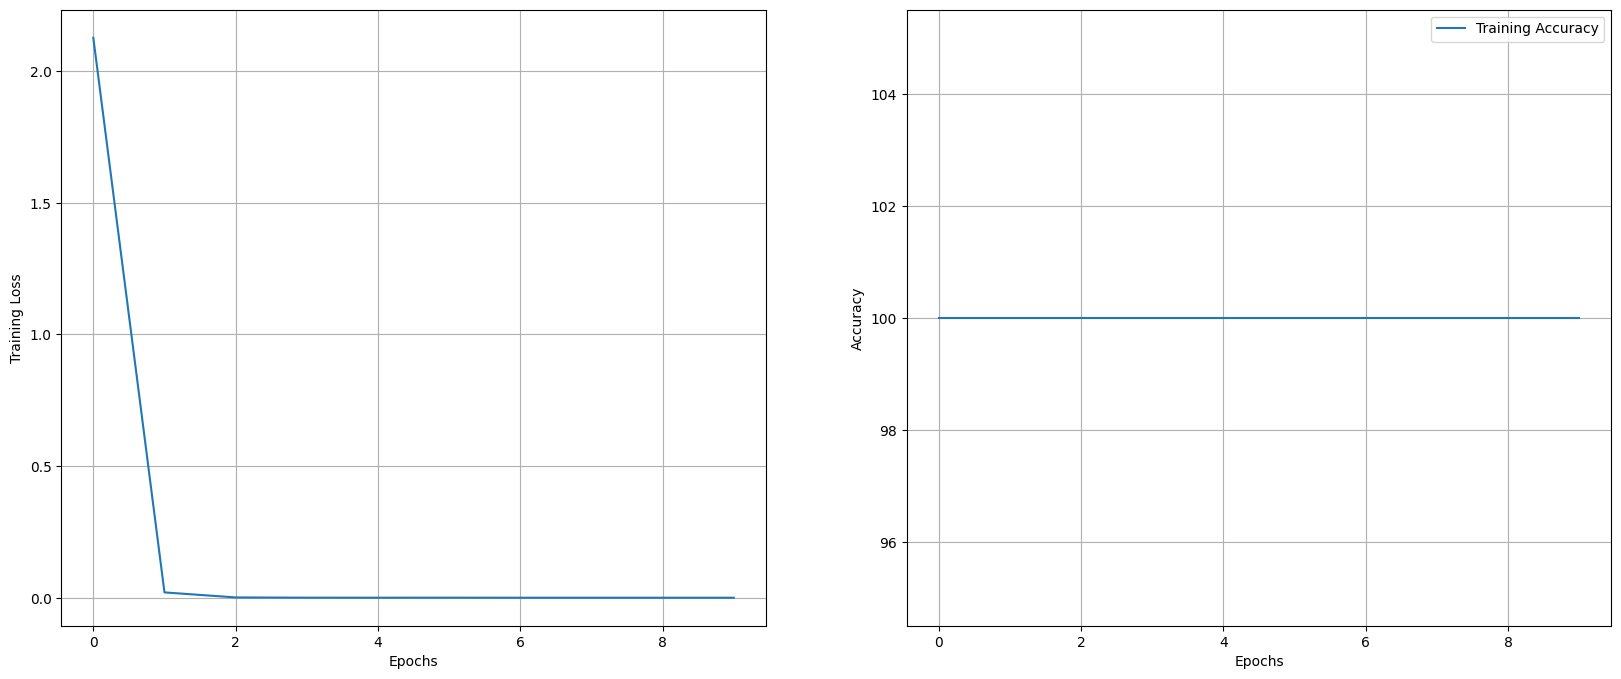

In [22]:
checkModel = copy.deepcopy(NewModel)
checkModel.to(device)
# Create a StepLR scheduler
optimizer = optim.AdamW(params=checkModel.parameters(), lr=0.001)
#, momentum=0.9, weight_decay=0.0001)
# optimizer = optim.Adam(params=checkModel.parameters(), lr=0.0001, weight_decay=0)

torch.cuda.empty_cache()
gc.collect()

adamW_training_loss, adamW_training_accuracy = overfit_model(checkModel, SampleLoader, optimizer, criterion, num_epochs=10)
plot_training_plots(training_loss=adamW_training_loss, training_accuracy=adamW_training_accuracy)

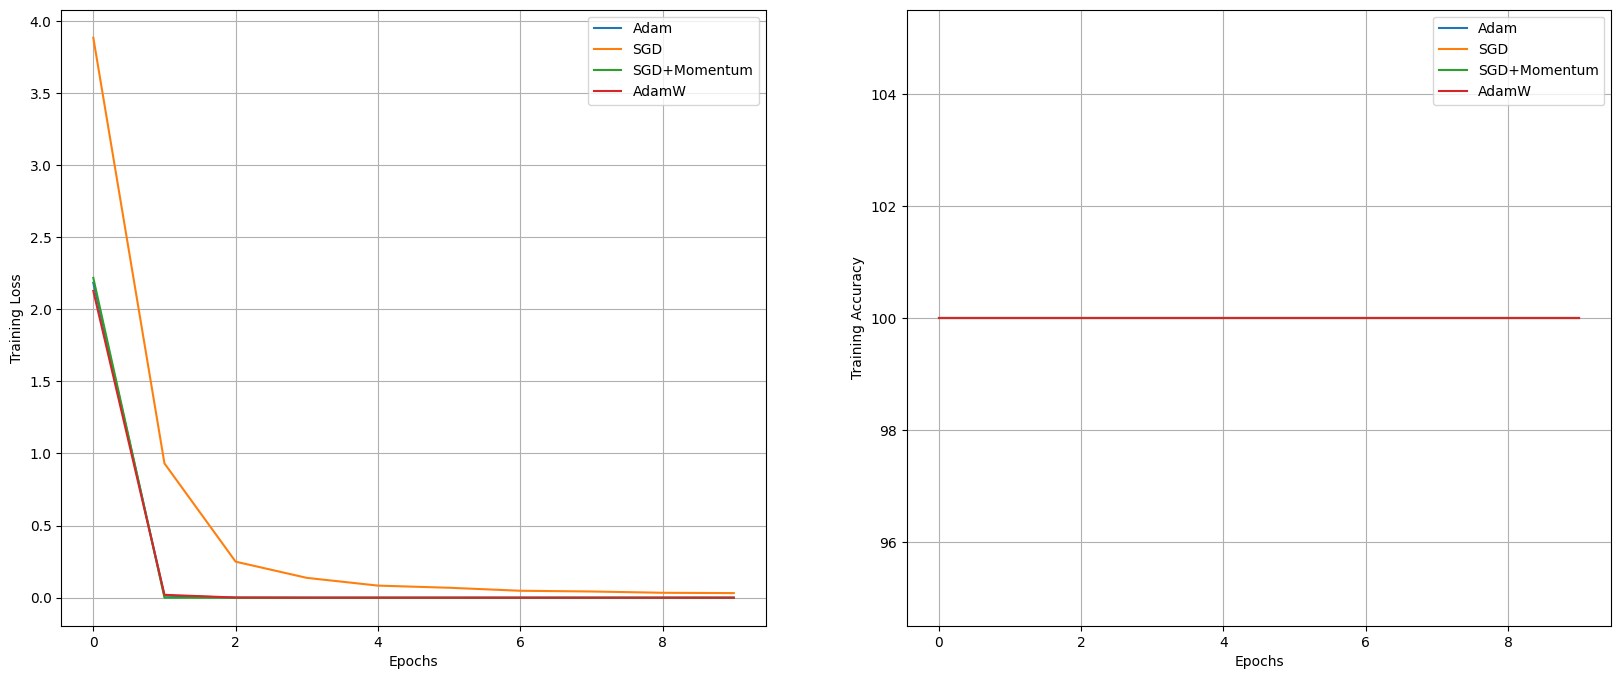

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(range(len(adam_training_loss)), adam_training_loss, label='Adam')
ax[0].plot(range(len(sgd_training_loss)), sgd_training_loss, label='SGD')
ax[0].plot(range(len(msgd_training_loss)), msgd_training_loss, label='SGD+Momentum')
ax[0].plot(range(len(adamW_training_loss)), adamW_training_loss, label='AdamW')

ax[1].plot(range(len(adam_training_accuracy)), adam_training_accuracy, label='Adam')
ax[1].plot(range(len(sgd_training_accuracy)), sgd_training_accuracy, label='SGD')
ax[1].plot(range(len(msgd_training_accuracy)), msgd_training_accuracy, label='SGD+Momentum')
ax[1].plot(range(len(adamW_training_accuracy)), adamW_training_accuracy, label='AdamW')

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Training Accuracy')

plt.show()

## Find Learning Rate that makes loss go down

Use the architecture from the previous step and use all training data, turn on small weight decay, find learning rate that makes the loss drop significantly (within 100 iterations)

Good learning rates: 1e-1, 1e-2, 1e-3, 1e-4

0.1


100%|██████████| 2400/2400 [02:19<00:00, 17.19it/s]


Epoch [1/10], Loss: 5.6205


100%|██████████| 2400/2400 [00:24<00:00, 97.10it/s] 


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [01:23<00:00, 28.79it/s]


Epoch [2/10], Loss: 5.4966


100%|██████████| 2400/2400 [00:25<00:00, 92.65it/s] 


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [01:19<00:00, 30.35it/s]


Epoch [3/10], Loss: 4.6862


100%|██████████| 2400/2400 [00:27<00:00, 88.48it/s] 


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [01:29<00:00, 26.85it/s]


Epoch [4/10], Loss: 5.6946


100%|██████████| 2400/2400 [00:25<00:00, 95.64it/s] 


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [01:44<00:00, 22.93it/s]


Epoch [5/10], Loss: 5.1902


100%|██████████| 2400/2400 [00:29<00:00, 82.24it/s] 


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [02:36<00:00, 15.34it/s]


Epoch [6/10], Loss: 6.3870


100%|██████████| 2400/2400 [00:40<00:00, 59.64it/s] 


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [02:13<00:00, 17.98it/s]


Epoch [7/10], Loss: 6.0536


100%|██████████| 2400/2400 [00:43<00:00, 55.80it/s] 


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [05:06<00:00,  7.83it/s]


Epoch [8/10], Loss: 5.3250


100%|██████████| 2400/2400 [00:11<00:00, 213.15it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:35<00:00, 68.29it/s]


Epoch [9/10], Loss: 7.5515


100%|██████████| 2400/2400 [00:11<00:00, 214.49it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:37<00:00, 64.11it/s]


Epoch [10/10], Loss: 4.5921


100%|██████████| 2400/2400 [00:12<00:00, 190.61it/s]


Accuracy of the network on the 2400 train images: 0.5
0.01


100%|██████████| 2400/2400 [00:35<00:00, 66.97it/s]


Epoch [1/10], Loss: 5.1889


100%|██████████| 2400/2400 [00:12<00:00, 193.64it/s]


Accuracy of the network on the 2400 train images: 0.8125


100%|██████████| 2400/2400 [00:36<00:00, 66.57it/s]


Epoch [2/10], Loss: 5.2321


100%|██████████| 2400/2400 [00:12<00:00, 195.41it/s]


Accuracy of the network on the 2400 train images: 0.4791666666666667


100%|██████████| 2400/2400 [00:36<00:00, 65.31it/s]


Epoch [3/10], Loss: 5.2691


100%|██████████| 2400/2400 [00:12<00:00, 195.34it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:35<00:00, 67.05it/s]


Epoch [4/10], Loss: 5.4796


100%|██████████| 2400/2400 [00:12<00:00, 196.25it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:36<00:00, 64.98it/s]


Epoch [5/10], Loss: 5.2862


100%|██████████| 2400/2400 [00:12<00:00, 195.45it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:36<00:00, 66.12it/s]


Epoch [6/10], Loss: 5.0901


100%|██████████| 2400/2400 [00:12<00:00, 194.21it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:36<00:00, 66.09it/s]


Epoch [7/10], Loss: 5.4132


100%|██████████| 2400/2400 [00:12<00:00, 193.41it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:36<00:00, 66.25it/s]


Epoch [8/10], Loss: 5.3115


100%|██████████| 2400/2400 [00:12<00:00, 194.72it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:36<00:00, 66.06it/s]


Epoch [9/10], Loss: 5.2729


100%|██████████| 2400/2400 [00:12<00:00, 196.04it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:35<00:00, 66.96it/s]


Epoch [10/10], Loss: 5.3719


100%|██████████| 2400/2400 [00:12<00:00, 196.61it/s]


Accuracy of the network on the 2400 train images: 0.5
0.001


100%|██████████| 2400/2400 [00:36<00:00, 65.36it/s]


Epoch [1/10], Loss: 5.0539


100%|██████████| 2400/2400 [00:13<00:00, 178.90it/s]


Accuracy of the network on the 2400 train images: 0.7291666666666666


100%|██████████| 2400/2400 [00:37<00:00, 63.42it/s]


Epoch [2/10], Loss: 5.7136


100%|██████████| 2400/2400 [00:12<00:00, 185.82it/s]


Accuracy of the network on the 2400 train images: 0.6666666666666666


100%|██████████| 2400/2400 [00:36<00:00, 65.65it/s]


Epoch [3/10], Loss: 5.4037


100%|██████████| 2400/2400 [00:13<00:00, 182.62it/s]


Accuracy of the network on the 2400 train images: 0.5208333333333334


100%|██████████| 2400/2400 [00:38<00:00, 62.67it/s]


Epoch [4/10], Loss: 4.7738


100%|██████████| 2400/2400 [00:13<00:00, 177.28it/s]


Accuracy of the network on the 2400 train images: 1.2291666666666667


100%|██████████| 2400/2400 [00:37<00:00, 63.81it/s]


Epoch [5/10], Loss: 5.4031


100%|██████████| 2400/2400 [00:13<00:00, 180.51it/s]


Accuracy of the network on the 2400 train images: 0.6458333333333334


100%|██████████| 2400/2400 [00:40<00:00, 59.68it/s]


Epoch [6/10], Loss: 5.2859


100%|██████████| 2400/2400 [00:13<00:00, 176.27it/s]


Accuracy of the network on the 2400 train images: 0.9583333333333334


100%|██████████| 2400/2400 [00:38<00:00, 62.98it/s]


Epoch [7/10], Loss: 4.7242


100%|██████████| 2400/2400 [00:12<00:00, 189.26it/s]


Accuracy of the network on the 2400 train images: 1.5416666666666667


100%|██████████| 2400/2400 [00:39<00:00, 61.43it/s]


Epoch [8/10], Loss: 4.6834


100%|██████████| 2400/2400 [00:13<00:00, 184.00it/s]


Accuracy of the network on the 2400 train images: 1.875


100%|██████████| 2400/2400 [00:36<00:00, 65.98it/s]


Epoch [9/10], Loss: 5.6766


100%|██████████| 2400/2400 [00:13<00:00, 178.60it/s]


Accuracy of the network on the 2400 train images: 2.2916666666666665


100%|██████████| 2400/2400 [00:40<00:00, 59.23it/s]


Epoch [10/10], Loss: 5.2034


100%|██████████| 2400/2400 [00:14<00:00, 166.32it/s]


Accuracy of the network on the 2400 train images: 3.0208333333333335
0.0001


100%|██████████| 2400/2400 [00:38<00:00, 62.75it/s]


Epoch [1/10], Loss: 4.4309


100%|██████████| 2400/2400 [00:12<00:00, 189.96it/s]


Accuracy of the network on the 2400 train images: 26.0


100%|██████████| 2400/2400 [00:38<00:00, 61.68it/s]


Epoch [2/10], Loss: 3.8197


100%|██████████| 2400/2400 [00:15<00:00, 156.76it/s]


Accuracy of the network on the 2400 train images: 41.4375


100%|██████████| 2400/2400 [00:42<00:00, 56.67it/s]


Epoch [3/10], Loss: 1.6072


100%|██████████| 2400/2400 [00:13<00:00, 175.73it/s]


Accuracy of the network on the 2400 train images: 54.104166666666664


100%|██████████| 2400/2400 [00:48<00:00, 49.22it/s]


Epoch [4/10], Loss: 2.6950


100%|██████████| 2400/2400 [00:13<00:00, 174.99it/s]


Accuracy of the network on the 2400 train images: 68.6875


100%|██████████| 2400/2400 [00:47<00:00, 50.56it/s]


Epoch [5/10], Loss: 1.4214


100%|██████████| 2400/2400 [00:12<00:00, 194.96it/s]


Accuracy of the network on the 2400 train images: 83.66666666666667


100%|██████████| 2400/2400 [01:06<00:00, 36.12it/s]


Epoch [6/10], Loss: 0.9036


100%|██████████| 2400/2400 [00:14<00:00, 169.79it/s]


Accuracy of the network on the 2400 train images: 88.4375


100%|██████████| 2400/2400 [00:54<00:00, 44.18it/s]


Epoch [7/10], Loss: 0.1569


100%|██████████| 2400/2400 [00:12<00:00, 194.78it/s]


Accuracy of the network on the 2400 train images: 92.875


100%|██████████| 2400/2400 [01:21<00:00, 29.50it/s]


Epoch [8/10], Loss: 0.6146


100%|██████████| 2400/2400 [00:15<00:00, 156.96it/s]


Accuracy of the network on the 2400 train images: 95.02083333333333


100%|██████████| 2400/2400 [00:42<00:00, 56.94it/s]


Epoch [9/10], Loss: 0.2650


100%|██████████| 2400/2400 [00:11<00:00, 215.64it/s]


Accuracy of the network on the 2400 train images: 97.29166666666667


100%|██████████| 2400/2400 [00:38<00:00, 63.11it/s]


Epoch [10/10], Loss: 0.1545


100%|██████████| 2400/2400 [00:14<00:00, 164.12it/s]


Accuracy of the network on the 2400 train images: 97.35416666666667
1e-05


100%|██████████| 2400/2400 [00:51<00:00, 46.79it/s]


Epoch [1/10], Loss: 4.6510


100%|██████████| 2400/2400 [00:20<00:00, 118.58it/s]


Accuracy of the network on the 2400 train images: 8.833333333333334


100%|██████████| 2400/2400 [00:39<00:00, 61.23it/s]


Epoch [2/10], Loss: 4.9549


100%|██████████| 2400/2400 [00:11<00:00, 200.17it/s]


Accuracy of the network on the 2400 train images: 22.270833333333332


100%|██████████| 2400/2400 [00:39<00:00, 60.98it/s]


Epoch [3/10], Loss: 4.2448


100%|██████████| 2400/2400 [00:11<00:00, 200.59it/s]


Accuracy of the network on the 2400 train images: 36.5


100%|██████████| 2400/2400 [00:39<00:00, 61.54it/s]


Epoch [4/10], Loss: 4.1380


100%|██████████| 2400/2400 [00:11<00:00, 209.70it/s]


Accuracy of the network on the 2400 train images: 48.458333333333336


100%|██████████| 2400/2400 [00:43<00:00, 55.44it/s]


Epoch [5/10], Loss: 4.2917


100%|██████████| 2400/2400 [00:11<00:00, 202.94it/s]


Accuracy of the network on the 2400 train images: 55.604166666666664


100%|██████████| 2400/2400 [00:37<00:00, 63.18it/s]


Epoch [6/10], Loss: 3.9463


100%|██████████| 2400/2400 [00:11<00:00, 208.38it/s]


Accuracy of the network on the 2400 train images: 63.5


100%|██████████| 2400/2400 [00:41<00:00, 58.49it/s]


Epoch [7/10], Loss: 4.2942


100%|██████████| 2400/2400 [00:12<00:00, 198.77it/s]


Accuracy of the network on the 2400 train images: 68.1875


100%|██████████| 2400/2400 [00:34<00:00, 69.44it/s]


Epoch [8/10], Loss: 4.3063


100%|██████████| 2400/2400 [00:11<00:00, 202.89it/s]


Accuracy of the network on the 2400 train images: 75.29166666666667


100%|██████████| 2400/2400 [00:47<00:00, 50.38it/s]


Epoch [9/10], Loss: 3.7005


100%|██████████| 2400/2400 [00:21<00:00, 112.66it/s]


Accuracy of the network on the 2400 train images: 77.5625


100%|██████████| 2400/2400 [00:48<00:00, 49.25it/s]


Epoch [10/10], Loss: 2.6453


100%|██████████| 2400/2400 [00:24<00:00, 98.47it/s] 

Accuracy of the network on the 2400 train images: 81.3125


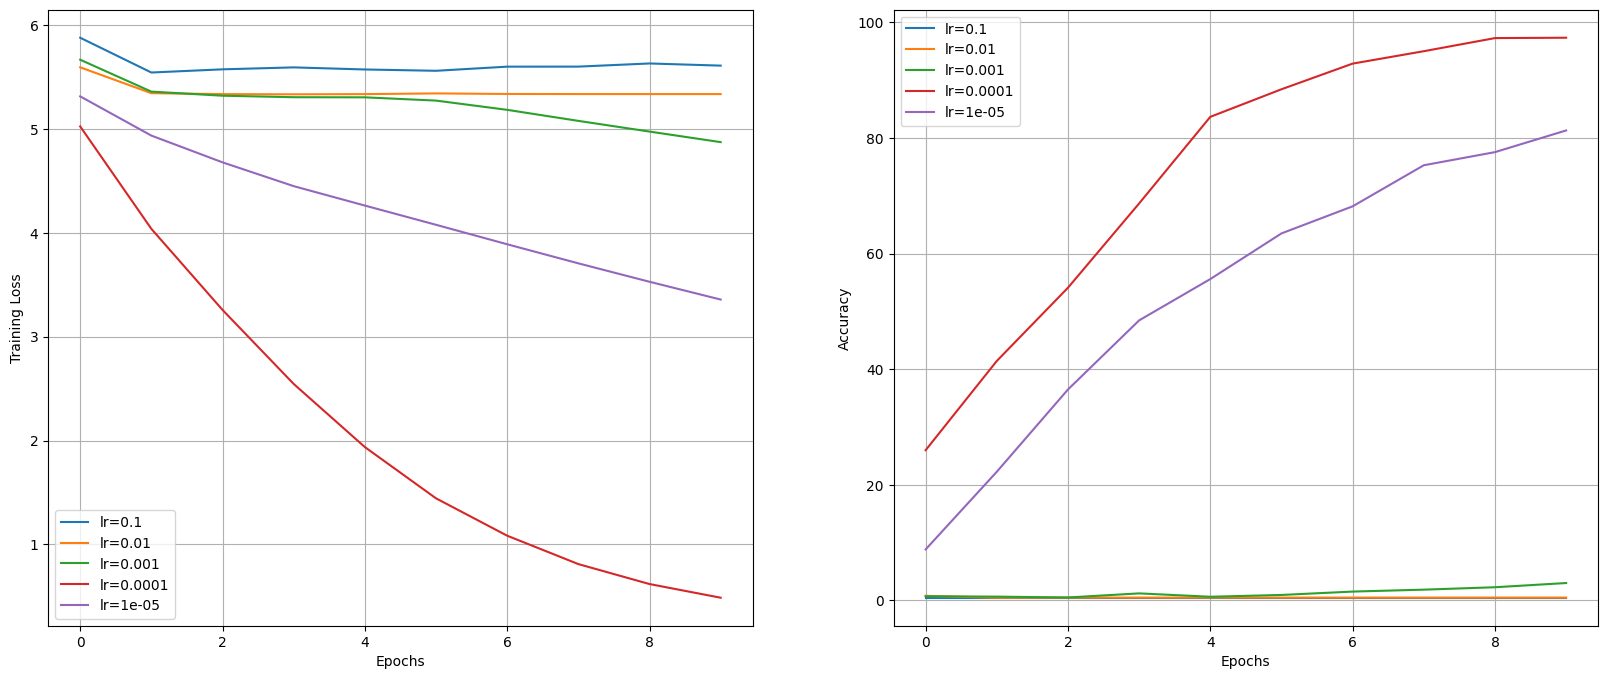

In [24]:
adam_lr_loss, adam_lr_accuracy = [], []
lr_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for lr in lr_rates:
    print(lr)
    checkModel = copy.deepcopy(NewModel)
    checkModel.to(device)

    optimizer = optim.Adam(params=checkModel.parameters(), lr=lr, weight_decay=0.0001)

    torch.cuda.empty_cache()
    gc.collect()

    training_loss, training_accuracy = overfit_model(checkModel, TrainLoader, 
                                                        optimizer, criterion, num_epochs=10)

    adam_lr_loss.append(training_loss)
    adam_lr_accuracy.append(training_accuracy)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i in range(len(lr_rates)):
    ax[0].plot(range(len(adam_lr_loss[i])), adam_lr_loss[i], label=f"lr={lr_rates[i]}")
    ax[1].plot(range(len(adam_lr_accuracy[i])), adam_lr_accuracy[i], label=f"lr={lr_rates[i]}")

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Accuracy')
plt.show()

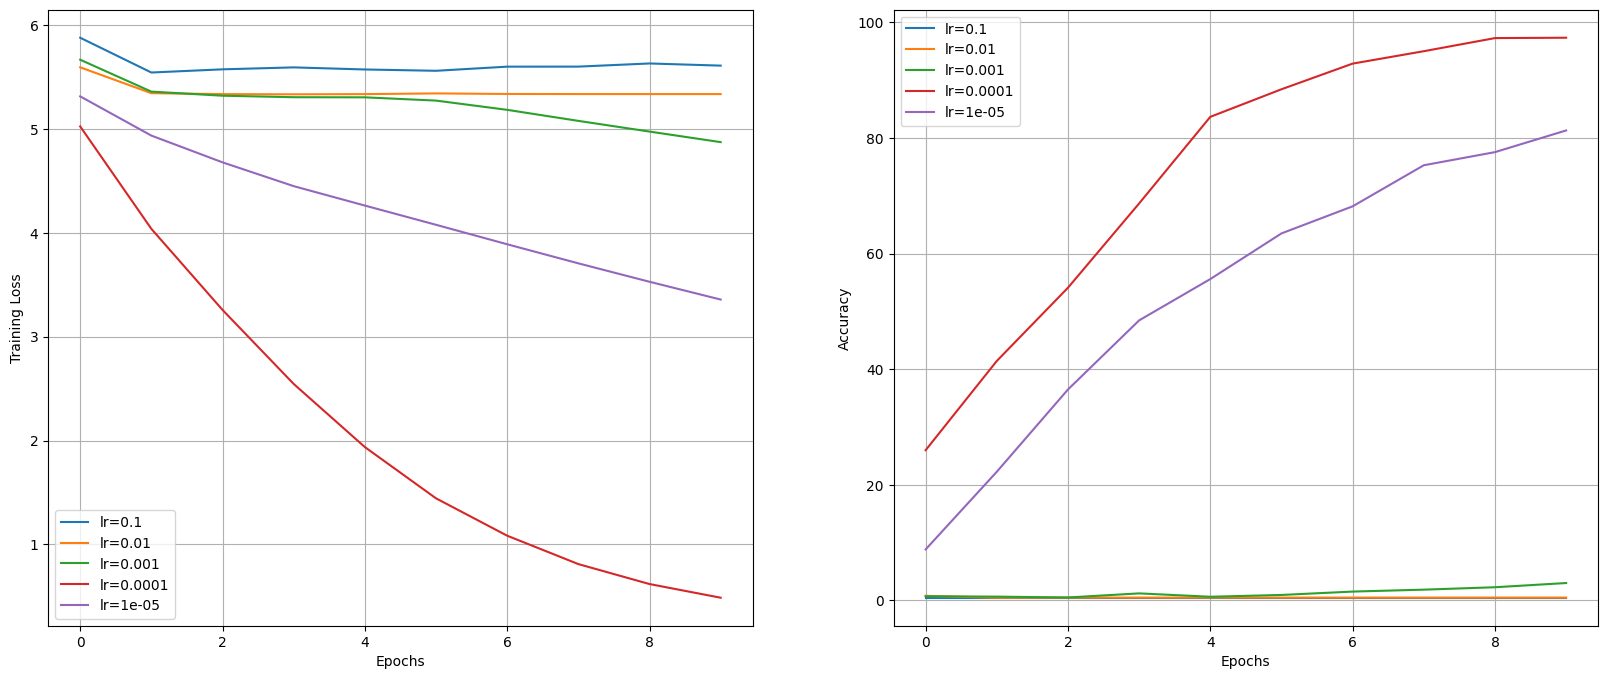

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i in range(len(lr_rates)):
    ax[0].plot(range(len(adam_lr_loss[i])), adam_lr_loss[i], label=f"lr={lr_rates[i]}")
    ax[1].plot(range(len(adam_lr_accuracy[i])), adam_lr_accuracy[i], label=f"lr={lr_rates[i]}")

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Accuracy')
plt.show()

## Coarse grid (train for 1-5 epochs)

Choose a few values of learning rate and weight decay around what worked on step 3, tain a few models for 1-5 epochs

Good weight decay to try: 1e-4, 1e-5, 0

In [46]:
np.random.uniform(3/4 * 1e-3, 4/3 * 1e-3, size=9)

array([0.00117511, 0.00099065, 0.0012461 , 0.00084475, 0.00132516,
       0.00120026, 0.00081308, 0.00130678, 0.00112064])

In [40]:
adam_lr_wd_loss, adam_lr_wd_accuracy = [], []
# lr_rates = np.random.uniform(3/4 * 1e-3, 4/3 * 1e-3, size=9)
# lr_rates = [1e-2, 1e-3, 1e-4, 1e-5]
weight_decay = np.array([0, 1e-4, 1e-5])

for lr in lr_rates:
    for wd in weight_decay:
        print(f"lr={lr}, wd={wd}")
        checkModel = copy.deepcopy(NewModel)
        checkModel.to(device)

        optimizer = optim.Adam(params=checkModel.parameters(), lr=lr, weight_decay=wd)

        torch.cuda.empty_cache()
        gc.collect()

        training_loss, training_accuracy = overfit_model(checkModel, TrainLoader, 
                                                            optimizer, criterion, num_epochs=5)

        adam_lr_wd_loss.append(training_loss)
        adam_lr_wd_accuracy.append(training_accuracy)
        print()


lr=0.1, wd=0.0


100%|██████████| 2400/2400 [00:50<00:00, 47.50it/s]


Epoch [1/5], Loss: 4.7980


100%|██████████| 2400/2400 [00:34<00:00, 69.31it/s]


Accuracy of the network on the 2400 train images: 0.4375


100%|██████████| 2400/2400 [00:47<00:00, 50.90it/s]


Epoch [2/5], Loss: 5.5865


100%|██████████| 2400/2400 [00:36<00:00, 65.18it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:47<00:00, 50.19it/s]


Epoch [3/5], Loss: 5.4701


100%|██████████| 2400/2400 [00:36<00:00, 65.42it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:47<00:00, 50.21it/s]


Epoch [4/5], Loss: 5.5074


100%|██████████| 2400/2400 [00:35<00:00, 66.97it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:48<00:00, 49.42it/s]


Epoch [5/5], Loss: 5.1914


100%|██████████| 2400/2400 [00:37<00:00, 64.67it/s]


Accuracy of the network on the 2400 train images: 0.5

lr=0.1, wd=0.0001


100%|██████████| 2400/2400 [00:48<00:00, 49.89it/s]


Epoch [1/5], Loss: 15.1603


100%|██████████| 2400/2400 [00:35<00:00, 66.80it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:48<00:00, 49.36it/s]


Epoch [2/5], Loss: 5.2134


100%|██████████| 2400/2400 [00:40<00:00, 59.63it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:48<00:00, 49.79it/s]


Epoch [3/5], Loss: 5.6563


100%|██████████| 2400/2400 [00:38<00:00, 61.90it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:48<00:00, 49.97it/s]


Epoch [4/5], Loss: 5.5805


100%|██████████| 2400/2400 [00:37<00:00, 64.73it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:53<00:00, 44.95it/s]


Epoch [5/5], Loss: 5.9833


100%|██████████| 2400/2400 [00:30<00:00, 78.84it/s] 


Accuracy of the network on the 2400 train images: 0.5

lr=0.1, wd=1e-05


100%|██████████| 2400/2400 [00:26<00:00, 89.41it/s] 


Epoch [1/5], Loss: 5.6442


100%|██████████| 2400/2400 [00:18<00:00, 130.94it/s]


Accuracy of the network on the 2400 train images: 0.6041666666666666


100%|██████████| 2400/2400 [00:27<00:00, 85.94it/s] 


Epoch [2/5], Loss: 5.5965


100%|██████████| 2400/2400 [00:19<00:00, 123.81it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:28<00:00, 83.02it/s] 


Epoch [3/5], Loss: 5.9316


100%|██████████| 2400/2400 [00:20<00:00, 119.19it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:28<00:00, 83.91it/s] 


Epoch [4/5], Loss: 6.5599


100%|██████████| 2400/2400 [00:20<00:00, 117.05it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:28<00:00, 85.21it/s] 


Epoch [5/5], Loss: 5.5559


100%|██████████| 2400/2400 [00:19<00:00, 120.05it/s]


Accuracy of the network on the 2400 train images: 0.5

lr=0.01, wd=0.0


100%|██████████| 2400/2400 [00:28<00:00, 84.85it/s] 


Epoch [1/5], Loss: 5.3755


100%|██████████| 2400/2400 [00:19<00:00, 123.97it/s]


Accuracy of the network on the 2400 train images: 0.625


100%|██████████| 2400/2400 [00:28<00:00, 82.87it/s] 


Epoch [2/5], Loss: 5.2667


100%|██████████| 2400/2400 [00:19<00:00, 120.91it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:25<00:00, 92.43it/s] 


Epoch [3/5], Loss: 5.4902


100%|██████████| 2400/2400 [00:18<00:00, 127.80it/s]


Accuracy of the network on the 2400 train images: 0.5208333333333334


100%|██████████| 2400/2400 [00:26<00:00, 91.06it/s] 


Epoch [4/5], Loss: 5.3635


100%|██████████| 2400/2400 [00:20<00:00, 117.52it/s]


Accuracy of the network on the 2400 train images: 0.5208333333333334


100%|██████████| 2400/2400 [00:25<00:00, 93.70it/s] 


Epoch [5/5], Loss: 5.4357


100%|██████████| 2400/2400 [00:20<00:00, 119.84it/s]


Accuracy of the network on the 2400 train images: 0.5

lr=0.01, wd=0.0001


100%|██████████| 2400/2400 [00:25<00:00, 92.71it/s] 


Epoch [1/5], Loss: 5.3228


100%|██████████| 2400/2400 [00:20<00:00, 118.65it/s]


Accuracy of the network on the 2400 train images: 0.5416666666666666


100%|██████████| 2400/2400 [00:25<00:00, 92.59it/s] 


Epoch [2/5], Loss: 5.4248


100%|██████████| 2400/2400 [00:20<00:00, 117.24it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:25<00:00, 92.88it/s] 


Epoch [3/5], Loss: 5.4357


100%|██████████| 2400/2400 [00:19<00:00, 120.33it/s]


Accuracy of the network on the 2400 train images: 0.4583333333333333


100%|██████████| 2400/2400 [00:27<00:00, 88.77it/s] 


Epoch [4/5], Loss: 5.2664


100%|██████████| 2400/2400 [00:21<00:00, 112.42it/s]


Accuracy of the network on the 2400 train images: 0.6041666666666666


100%|██████████| 2400/2400 [00:26<00:00, 89.51it/s] 


Epoch [5/5], Loss: 5.2017


100%|██████████| 2400/2400 [00:21<00:00, 113.26it/s]


Accuracy of the network on the 2400 train images: 0.6666666666666666

lr=0.01, wd=1e-05


100%|██████████| 2400/2400 [00:27<00:00, 88.60it/s] 


Epoch [1/5], Loss: 5.3592


100%|██████████| 2400/2400 [00:21<00:00, 111.37it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:27<00:00, 88.80it/s] 


Epoch [2/5], Loss: 5.1473


100%|██████████| 2400/2400 [00:21<00:00, 113.14it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:27<00:00, 88.52it/s] 


Epoch [3/5], Loss: 5.2774


100%|██████████| 2400/2400 [00:21<00:00, 113.22it/s]


Accuracy of the network on the 2400 train images: 0.5208333333333334


100%|██████████| 2400/2400 [00:27<00:00, 87.76it/s] 


Epoch [4/5], Loss: 5.3913


100%|██████████| 2400/2400 [00:21<00:00, 112.31it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:25<00:00, 94.89it/s] 


Epoch [5/5], Loss: 5.2592


100%|██████████| 2400/2400 [00:21<00:00, 113.95it/s]


Accuracy of the network on the 2400 train images: 0.4166666666666667

lr=0.001, wd=0.0


100%|██████████| 2400/2400 [00:25<00:00, 95.46it/s] 


Epoch [1/5], Loss: 5.3371


100%|██████████| 2400/2400 [00:21<00:00, 112.80it/s]


Accuracy of the network on the 2400 train images: 0.4166666666666667


100%|██████████| 2400/2400 [00:25<00:00, 93.44it/s] 


Epoch [2/5], Loss: 5.3235


100%|██████████| 2400/2400 [00:20<00:00, 117.76it/s]


Accuracy of the network on the 2400 train images: 0.7916666666666666


100%|██████████| 2400/2400 [00:25<00:00, 93.49it/s] 


Epoch [3/5], Loss: 4.0855


100%|██████████| 2400/2400 [00:20<00:00, 115.90it/s]


Accuracy of the network on the 2400 train images: 1.2291666666666667


100%|██████████| 2400/2400 [00:26<00:00, 92.13it/s] 


Epoch [4/5], Loss: 4.9484


100%|██████████| 2400/2400 [00:20<00:00, 117.66it/s]


Accuracy of the network on the 2400 train images: 1.6666666666666667


100%|██████████| 2400/2400 [00:25<00:00, 93.32it/s] 


Epoch [5/5], Loss: 6.1743


100%|██████████| 2400/2400 [00:20<00:00, 114.83it/s]


Accuracy of the network on the 2400 train images: 2.0208333333333335

lr=0.001, wd=0.0001


100%|██████████| 2400/2400 [00:29<00:00, 82.65it/s] 


Epoch [1/5], Loss: 5.3364


100%|██████████| 2400/2400 [00:19<00:00, 121.21it/s]


Accuracy of the network on the 2400 train images: 0.625


100%|██████████| 2400/2400 [00:29<00:00, 82.42it/s] 


Epoch [2/5], Loss: 5.3262


100%|██████████| 2400/2400 [00:19<00:00, 120.99it/s]


Accuracy of the network on the 2400 train images: 0.875


100%|██████████| 2400/2400 [00:29<00:00, 82.52it/s] 


Epoch [3/5], Loss: 5.3064


100%|██████████| 2400/2400 [00:20<00:00, 118.46it/s]


Accuracy of the network on the 2400 train images: 0.6666666666666666


100%|██████████| 2400/2400 [00:29<00:00, 82.18it/s]


Epoch [4/5], Loss: 5.3103


100%|██████████| 2400/2400 [00:20<00:00, 119.87it/s]


Accuracy of the network on the 2400 train images: 1.9791666666666667


100%|██████████| 2400/2400 [00:28<00:00, 82.80it/s] 


Epoch [5/5], Loss: 5.0626


100%|██████████| 2400/2400 [00:20<00:00, 119.99it/s]


Accuracy of the network on the 2400 train images: 3.6666666666666665

lr=0.001, wd=1e-05


100%|██████████| 2400/2400 [00:29<00:00, 82.47it/s]


Epoch [1/5], Loss: 5.4436


100%|██████████| 2400/2400 [00:19<00:00, 126.17it/s]


Accuracy of the network on the 2400 train images: 1.0208333333333333


100%|██████████| 2400/2400 [00:26<00:00, 90.25it/s] 


Epoch [2/5], Loss: 5.3532


100%|██████████| 2400/2400 [00:18<00:00, 130.71it/s]


Accuracy of the network on the 2400 train images: 1.1458333333333333


100%|██████████| 2400/2400 [00:27<00:00, 88.39it/s] 


Epoch [3/5], Loss: 4.2520


100%|██████████| 2400/2400 [00:19<00:00, 120.49it/s]


Accuracy of the network on the 2400 train images: 1.1666666666666667


100%|██████████| 2400/2400 [00:26<00:00, 91.19it/s] 


Epoch [4/5], Loss: 5.2503


100%|██████████| 2400/2400 [00:18<00:00, 129.24it/s]


Accuracy of the network on the 2400 train images: 0.9583333333333334


100%|██████████| 2400/2400 [00:28<00:00, 85.27it/s] 


Epoch [5/5], Loss: 5.1668


100%|██████████| 2400/2400 [00:18<00:00, 128.11it/s]


Accuracy of the network on the 2400 train images: 2.0833333333333335

lr=0.0001, wd=0.0


100%|██████████| 2400/2400 [00:26<00:00, 90.42it/s] 


Epoch [1/5], Loss: 5.2953


100%|██████████| 2400/2400 [00:21<00:00, 112.99it/s]


Accuracy of the network on the 2400 train images: 5.3125


100%|██████████| 2400/2400 [00:26<00:00, 89.54it/s] 


Epoch [2/5], Loss: 4.3768


100%|██████████| 2400/2400 [00:19<00:00, 121.31it/s]


Accuracy of the network on the 2400 train images: 13.270833333333334


100%|██████████| 2400/2400 [00:28<00:00, 84.10it/s] 


Epoch [3/5], Loss: 3.2767


100%|██████████| 2400/2400 [00:19<00:00, 123.35it/s]


Accuracy of the network on the 2400 train images: 20.6875


100%|██████████| 2400/2400 [00:28<00:00, 83.81it/s] 


Epoch [4/5], Loss: 4.1222


100%|██████████| 2400/2400 [00:19<00:00, 122.38it/s]


Accuracy of the network on the 2400 train images: 24.25


100%|██████████| 2400/2400 [00:28<00:00, 83.83it/s] 


Epoch [5/5], Loss: 2.8631


100%|██████████| 2400/2400 [00:19<00:00, 120.40it/s]


Accuracy of the network on the 2400 train images: 29.6875

lr=0.0001, wd=0.0001


100%|██████████| 2400/2400 [00:28<00:00, 83.22it/s] 


Epoch [1/5], Loss: 5.4416


100%|██████████| 2400/2400 [00:19<00:00, 121.53it/s]


Accuracy of the network on the 2400 train images: 6.5625


100%|██████████| 2400/2400 [00:29<00:00, 82.32it/s]


Epoch [2/5], Loss: 4.9625


100%|██████████| 2400/2400 [00:19<00:00, 123.49it/s]


Accuracy of the network on the 2400 train images: 10.916666666666666


100%|██████████| 2400/2400 [00:27<00:00, 86.62it/s] 


Epoch [3/5], Loss: 3.5018


100%|██████████| 2400/2400 [00:18<00:00, 128.12it/s]


Accuracy of the network on the 2400 train images: 19.625


100%|██████████| 2400/2400 [00:27<00:00, 88.49it/s] 


Epoch [4/5], Loss: 4.7126


100%|██████████| 2400/2400 [00:21<00:00, 112.10it/s]


Accuracy of the network on the 2400 train images: 21.604166666666668


100%|██████████| 2400/2400 [00:27<00:00, 88.65it/s] 


Epoch [5/5], Loss: 3.8363


100%|██████████| 2400/2400 [00:18<00:00, 127.43it/s]


Accuracy of the network on the 2400 train images: 27.75

lr=0.0001, wd=1e-05


100%|██████████| 2400/2400 [00:26<00:00, 89.84it/s] 


Epoch [1/5], Loss: 5.2184


100%|██████████| 2400/2400 [00:19<00:00, 125.71it/s]


Accuracy of the network on the 2400 train images: 5.145833333333333


100%|██████████| 2400/2400 [00:26<00:00, 89.90it/s] 


Epoch [2/5], Loss: 4.4727


100%|██████████| 2400/2400 [00:20<00:00, 118.03it/s]


Accuracy of the network on the 2400 train images: 10.104166666666666


100%|██████████| 2400/2400 [00:26<00:00, 90.85it/s] 


Epoch [3/5], Loss: 4.5122


100%|██████████| 2400/2400 [00:19<00:00, 124.27it/s]


Accuracy of the network on the 2400 train images: 17.291666666666668


100%|██████████| 2400/2400 [00:28<00:00, 84.18it/s]


Epoch [4/5], Loss: 4.4735


100%|██████████| 2400/2400 [00:19<00:00, 126.04it/s]


Accuracy of the network on the 2400 train images: 21.083333333333332


100%|██████████| 2400/2400 [00:28<00:00, 84.16it/s] 


Epoch [5/5], Loss: 3.0539


100%|██████████| 2400/2400 [00:20<00:00, 118.56it/s]


Accuracy of the network on the 2400 train images: 25.375

lr=1e-05, wd=0.0


100%|██████████| 2400/2400 [00:29<00:00, 82.51it/s] 


Epoch [1/5], Loss: 5.3404


100%|██████████| 2400/2400 [00:19<00:00, 122.37it/s]


Accuracy of the network on the 2400 train images: 1.7291666666666667


100%|██████████| 2400/2400 [00:28<00:00, 83.47it/s] 


Epoch [2/5], Loss: 5.2776


100%|██████████| 2400/2400 [00:20<00:00, 117.35it/s]


Accuracy of the network on the 2400 train images: 4.458333333333333


100%|██████████| 2400/2400 [00:29<00:00, 82.37it/s] 


Epoch [3/5], Loss: 5.2004


100%|██████████| 2400/2400 [00:19<00:00, 120.94it/s]


Accuracy of the network on the 2400 train images: 8.208333333333334


100%|██████████| 2400/2400 [00:28<00:00, 83.07it/s]


Epoch [4/5], Loss: 5.1269


100%|██████████| 2400/2400 [00:19<00:00, 121.39it/s]


Accuracy of the network on the 2400 train images: 13.354166666666666


100%|██████████| 2400/2400 [00:26<00:00, 89.91it/s] 


Epoch [5/5], Loss: 5.1006


100%|██████████| 2400/2400 [00:18<00:00, 128.88it/s]


Accuracy of the network on the 2400 train images: 15.5625

lr=1e-05, wd=0.0001


100%|██████████| 2400/2400 [00:26<00:00, 89.02it/s] 


Epoch [1/5], Loss: 5.3416


100%|██████████| 2400/2400 [00:18<00:00, 127.13it/s]


Accuracy of the network on the 2400 train images: 1.75


100%|██████████| 2400/2400 [00:26<00:00, 89.89it/s] 


Epoch [2/5], Loss: 5.2473


100%|██████████| 2400/2400 [00:18<00:00, 127.04it/s]


Accuracy of the network on the 2400 train images: 3.625


100%|██████████| 2400/2400 [00:26<00:00, 89.95it/s] 


Epoch [3/5], Loss: 5.2555


100%|██████████| 2400/2400 [00:20<00:00, 118.83it/s]


Accuracy of the network on the 2400 train images: 6.5625


100%|██████████| 2400/2400 [00:26<00:00, 89.41it/s] 


Epoch [4/5], Loss: 5.2348


100%|██████████| 2400/2400 [00:18<00:00, 127.12it/s]


Accuracy of the network on the 2400 train images: 11.979166666666666


100%|██████████| 2400/2400 [00:26<00:00, 90.33it/s] 


Epoch [5/5], Loss: 5.1422


100%|██████████| 2400/2400 [00:20<00:00, 115.82it/s]


Accuracy of the network on the 2400 train images: 14.916666666666666

lr=1e-05, wd=1e-05


100%|██████████| 2400/2400 [00:28<00:00, 83.05it/s] 


Epoch [1/5], Loss: 5.2732


100%|██████████| 2400/2400 [00:19<00:00, 121.82it/s]


Accuracy of the network on the 2400 train images: 1.875


100%|██████████| 2400/2400 [00:28<00:00, 83.77it/s] 


Epoch [2/5], Loss: 5.1772


100%|██████████| 2400/2400 [00:19<00:00, 121.51it/s]


Accuracy of the network on the 2400 train images: 3.7708333333333335


100%|██████████| 2400/2400 [00:26<00:00, 91.35it/s] 


Epoch [3/5], Loss: 5.1852


100%|██████████| 2400/2400 [00:21<00:00, 113.21it/s]


Accuracy of the network on the 2400 train images: 7.083333333333333


100%|██████████| 2400/2400 [00:26<00:00, 89.49it/s] 


Epoch [4/5], Loss: 5.2470


100%|██████████| 2400/2400 [00:21<00:00, 113.21it/s]


Accuracy of the network on the 2400 train images: 9.979166666666666


100%|██████████| 2400/2400 [00:26<00:00, 89.46it/s] 


Epoch [5/5], Loss: 5.0145


100%|██████████| 2400/2400 [00:21<00:00, 112.95it/s]

Accuracy of the network on the 2400 train images: 16.020833333333332



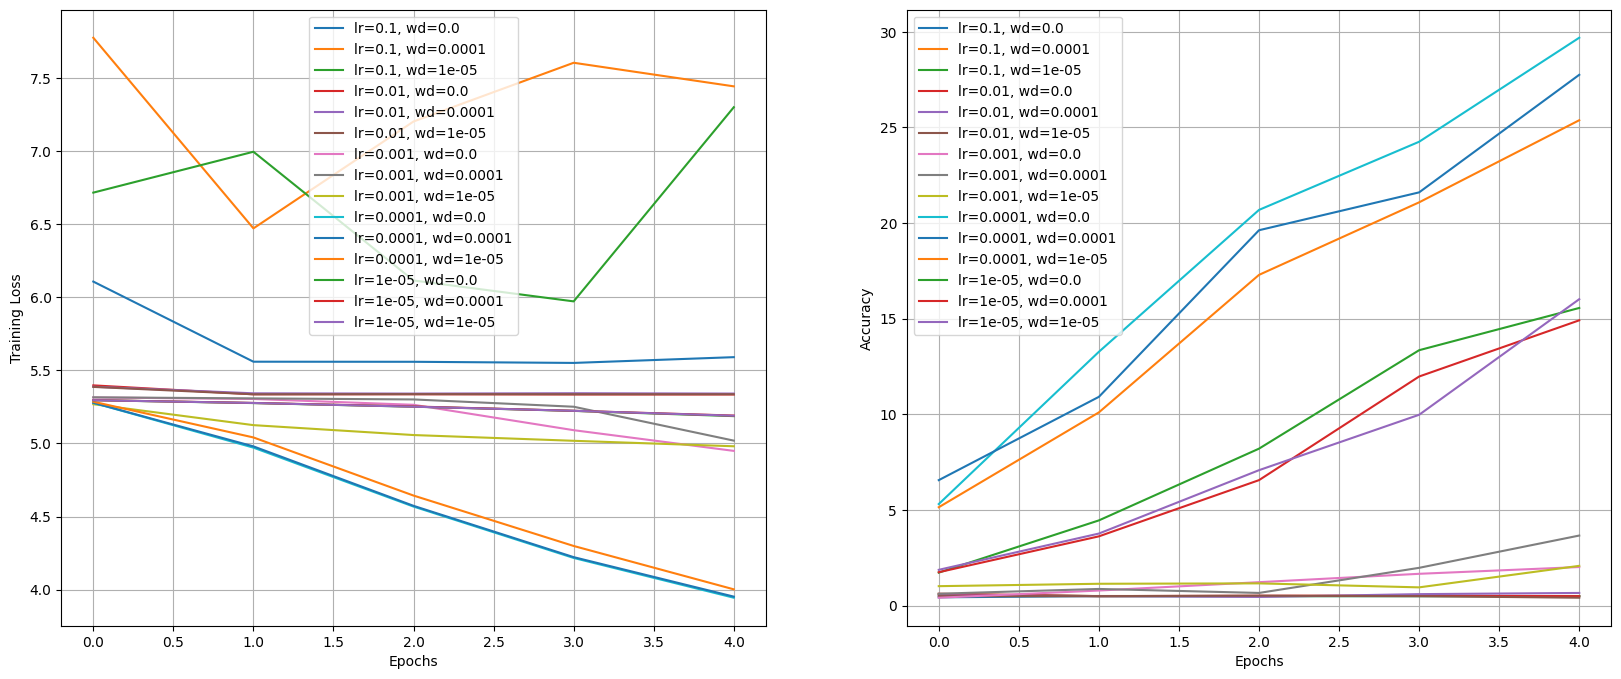

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i in range(len(lr_rates)):
    for j in range(len(weight_decay)):
        ax[0].plot(range(len(adam_lr_wd_loss[i * len(weight_decay) + j])), 
                   adam_lr_wd_loss[i * len(weight_decay) + j], 
                   label=f"lr={lr_rates[i]}, 
                   wd={weight_decay[j]}")
        
        ax[1].plot(range(len(adam_lr_wd_accuracy[i * len(weight_decay) + j])), 
                   adam_lr_wd_accuracy[i * len(weight_decay) + j], 
                   label=f"lr={lr_rates[i]}, 
                   wd={weight_decay[j]}")

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Accuracy')
plt.show()

## Refine grid, train longer

Pick best models from coarse grid, train them for longer (~10-20 epochs) without learning decay.

Check for
- Loss curves bad initialization:
    - if there is a plateau at the initial stage of the curve.
    - if there is a plateau at the end of the curve (implying the need for learning decay).
- Train and Validation accuracy curves:
    - Overfitting
    - Underfitting

In [ ]:
adam_wd_loss, adam_wd_accuracy = [], []
weight_decay = np.array([0, 1e-4, 1e-5])

lr=1e-4
for wd in weight_decay:
    print(f"lr={lr}, wd={wd}")
    checkModel = copy.deepcopy(NewModel)
    checkModel.to(device)

    optimizer = optim.Adam(params=checkModel.parameters(), lr=lr, weight_decay=wd)

    torch.cuda.empty_cache()
    gc.collect()

    training_loss, training_accuracy = overfit_model(checkModel, TrainLoader, 
                                                        optimizer, criterion, num_epochs=20)

    adam_wd_loss.append(training_loss)
    adam_wd_accuracy.append(training_accuracy)
    print()

# Training
There is a small error while printing loss. I printed final batch's loss after an epoch instead of whole batches' loss.

In [26]:
checkModel = copy.deepcopy(NewModel)
checkModel.to(device)

torch.cuda.empty_cache()
gc.collect()

training_accuracy = []
training_loss = []
validation_accuracy = []

# Number of epochs
num_epochs = 15

optimizer = optim.Adam(params=checkModel.parameters(), lr=1e-4, weight_decay=1e-4)

for epoch in range(num_epochs):
    checkModel.train()

    running_loss = 0    
    for input_data, labels in tqdm.tqdm(TrainLoader, total=len(TrainLoader)):
        # Forward pass
        labels, input_data = labels.to(device), input_data.to(device)
        output = checkModel(input_data)
        
        # Compute loss
        loss = criterion(output, labels.long())
        running_loss += loss.item()
        # Backward pass
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
    # scheduler.step(running_loss)  # Update learning rate
        
    # Print training progress
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    training_loss.append(running_loss / len(TrainLoader))

    training_accuracy.append(calculate_accuracy(checkModel, TrainLoader, data_type='train'))
    validation_accuracy.append(calculate_accuracy(checkModel, ValidationLoader, data_type='validation'))
    

    # if (epoch + 1) % 10 == 0:
    #     fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    #     ax[0].plot(range(len(training_loss)), training_loss)
    #     ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
    #     ax[1].plot(range(len(validation_accuracy)), validation_accuracy, label='Validation Accuracy')
    #     ax[1].grid()
    #     ax[0].grid()
    #     ax[0].set_xlabel('Epochs')
    #     ax[0].set_ylabel('Training Loss')
    #     ax[1].set_xlabel('Epochs')
    #     ax[1].set_ylabel('Accuracy')
    #     ax[1].legend()
    #     plt.show()
        # torch.save(checkModel.state_dict(), f"checkModel_{epoch}.pth")
calculate_accuracy(checkModel, TestLoader, data_type='test')

100%|██████████| 2400/2400 [00:39<00:00, 60.91it/s]


Epoch [1/15], Loss: 4.8857


100%|██████████| 2400/2400 [00:11<00:00, 200.12it/s]


Accuracy of the network on the 2400 train images: 22.25


100%|██████████| 597/597 [00:07<00:00, 80.50it/s] 


Accuracy of the network on the 597 validation images: 18.09045226130653


100%|██████████| 2400/2400 [00:40<00:00, 59.01it/s]


Epoch [2/15], Loss: 4.8379


100%|██████████| 2400/2400 [00:12<00:00, 192.53it/s]


Accuracy of the network on the 2400 train images: 44.0


100%|██████████| 597/597 [00:04<00:00, 121.68it/s]


Accuracy of the network on the 597 validation images: 32.74706867671692


100%|██████████| 2400/2400 [00:37<00:00, 64.52it/s]


Epoch [3/15], Loss: 2.9071


100%|██████████| 2400/2400 [00:13<00:00, 175.13it/s]


Accuracy of the network on the 2400 train images: 60.229166666666664


100%|██████████| 597/597 [00:05<00:00, 110.12it/s]


Accuracy of the network on the 597 validation images: 43.969849246231156


100%|██████████| 2400/2400 [00:38<00:00, 62.96it/s]


Epoch [4/15], Loss: 1.6271


100%|██████████| 2400/2400 [00:12<00:00, 186.11it/s]


Accuracy of the network on the 2400 train images: 75.02083333333333


100%|██████████| 597/597 [00:05<00:00, 114.29it/s]


Accuracy of the network on the 597 validation images: 55.27638190954774


100%|██████████| 2400/2400 [00:36<00:00, 65.37it/s]


Epoch [5/15], Loss: 2.2601


100%|██████████| 2400/2400 [00:12<00:00, 194.40it/s]


Accuracy of the network on the 2400 train images: 83.3125


100%|██████████| 597/597 [00:04<00:00, 122.66it/s]


Accuracy of the network on the 597 validation images: 60.552763819095475


100%|██████████| 2400/2400 [00:36<00:00, 66.57it/s]


Epoch [6/15], Loss: 0.5090


100%|██████████| 2400/2400 [00:12<00:00, 194.19it/s]


Accuracy of the network on the 2400 train images: 89.22916666666667


100%|██████████| 597/597 [00:04<00:00, 120.38it/s]


Accuracy of the network on the 597 validation images: 62.562814070351756


100%|██████████| 2400/2400 [00:36<00:00, 65.51it/s]


Epoch [7/15], Loss: 0.5166


100%|██████████| 2400/2400 [00:12<00:00, 194.70it/s]


Accuracy of the network on the 2400 train images: 94.45833333333333


100%|██████████| 597/597 [00:05<00:00, 111.39it/s]


Accuracy of the network on the 597 validation images: 64.321608040201


100%|██████████| 2400/2400 [00:37<00:00, 64.20it/s]


Epoch [8/15], Loss: 1.7986


100%|██████████| 2400/2400 [00:12<00:00, 187.88it/s]


Accuracy of the network on the 2400 train images: 95.91666666666667


100%|██████████| 597/597 [00:04<00:00, 121.00it/s]


Accuracy of the network on the 597 validation images: 64.99162479061977


100%|██████████| 2400/2400 [00:35<00:00, 66.71it/s]


Epoch [9/15], Loss: 1.3709


100%|██████████| 2400/2400 [00:12<00:00, 194.96it/s]


Accuracy of the network on the 2400 train images: 97.39583333333333


100%|██████████| 597/597 [00:04<00:00, 121.67it/s]


Accuracy of the network on the 597 validation images: 63.73534338358459


100%|██████████| 2400/2400 [00:37<00:00, 64.86it/s]


Epoch [10/15], Loss: 0.0923


100%|██████████| 2400/2400 [00:11<00:00, 203.03it/s]


Accuracy of the network on the 2400 train images: 97.58333333333333


100%|██████████| 597/597 [00:05<00:00, 114.56it/s]


Accuracy of the network on the 597 validation images: 63.90284757118928


100%|██████████| 2400/2400 [00:37<00:00, 63.53it/s]


Epoch [11/15], Loss: 0.9539


100%|██████████| 2400/2400 [00:13<00:00, 176.62it/s]


Accuracy of the network on the 2400 train images: 99.27083333333333


100%|██████████| 597/597 [00:04<00:00, 125.89it/s]


Accuracy of the network on the 597 validation images: 66.9179229480737


100%|██████████| 2400/2400 [00:39<00:00, 60.83it/s]


Epoch [12/15], Loss: 0.0526


100%|██████████| 2400/2400 [00:11<00:00, 211.96it/s]


Accuracy of the network on the 2400 train images: 99.3125


100%|██████████| 597/597 [00:04<00:00, 122.18it/s]


Accuracy of the network on the 597 validation images: 67.67169179229481


100%|██████████| 2400/2400 [00:37<00:00, 63.54it/s]


Epoch [13/15], Loss: 0.0745


100%|██████████| 2400/2400 [00:11<00:00, 209.23it/s]


Accuracy of the network on the 2400 train images: 99.25


100%|██████████| 597/597 [00:04<00:00, 129.08it/s]


Accuracy of the network on the 597 validation images: 65.9966499162479


100%|██████████| 2400/2400 [00:37<00:00, 64.05it/s]


Epoch [14/15], Loss: 0.0263


100%|██████████| 2400/2400 [00:11<00:00, 215.92it/s]


Accuracy of the network on the 2400 train images: 99.0625


100%|██████████| 597/597 [00:04<00:00, 122.98it/s]


Accuracy of the network on the 597 validation images: 65.74539363484087


100%|██████████| 2400/2400 [00:37<00:00, 64.29it/s]


Epoch [15/15], Loss: 0.5312


100%|██████████| 2400/2400 [00:11<00:00, 212.58it/s]


Accuracy of the network on the 2400 train images: 98.9375


100%|██████████| 597/597 [00:04<00:00, 131.51it/s]


Accuracy of the network on the 597 validation images: 65.91289782244556


100%|██████████| 2897/2897 [00:22<00:00, 126.65it/s]

Accuracy of the network on the 2897 test images: 66.84501208146358


66.84501208146358

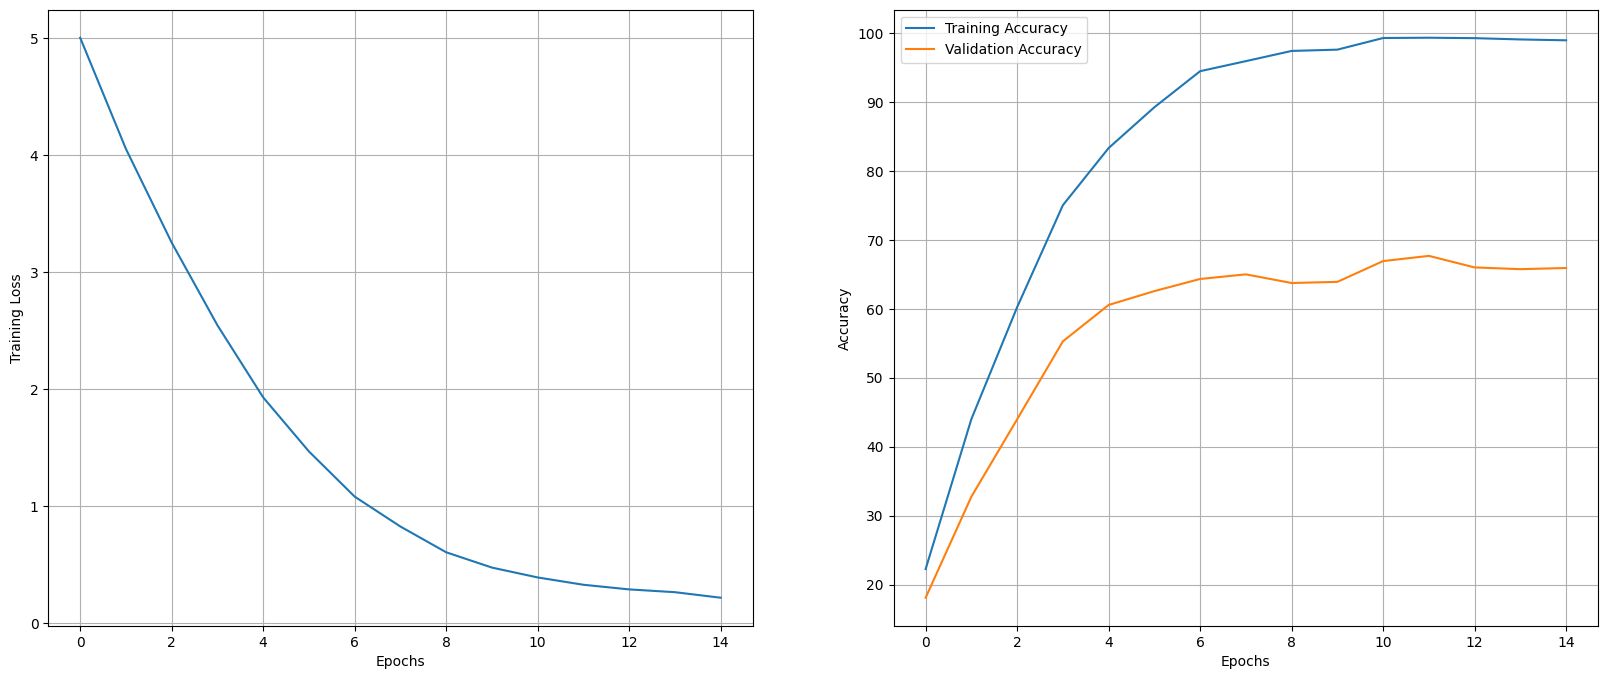

In [27]:

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(range(len(training_loss)), training_loss)
ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
ax[1].plot(range(len(validation_accuracy)), validation_accuracy, label='Validation Accuracy')
ax[1].grid()
ax[0].grid()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()
        # torch.save(checkModel.state_dict(), f"checkModel_{epoch}.pth")